In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

2024-06-11 20:46:55.923737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 20:46:56.527563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_files(folder):
    filenames = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png") and "imgs" in root:
                filenames.append(os.path.join(root, file))
    return filenames

In [3]:
files = get_files("data/")
train_paths = [(path, path.replace("imgs", "targets")) for path in files if "train" in path]
test_paths = [(path, path.replace("imgs", "targets")) for path in files if "test" in path]
val_paths = [(path, path.replace("imgs", "targets")) for path in files if "valid" in path]

print("Number of training samples: ", len(train_paths), 
      "\nNumber of validation samples: ", len(val_paths),
      "\nNumber of test samples: ", len(test_paths))

Number of training samples:  0 
Number of validation samples:  0 
Number of test samples:  0


In [4]:
def normalize_image(image):
    image = tf.cast(image, tf.float32) - tf.reduce_mean(image)
    image = image / tf.math.reduce_std(image)
    return image

def normalize_mask(mask):
    mask = tf.cast(mask, tf.float32)
    mask = mask / 255.0
    return mask

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, IMSIZE)
    return image


def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMSIZE)
    return mask

def load_image_pair(image_path):
    image = load_image(image_path[0])
    mask = load_mask(image_path[1])
    image = normalize_image(image)
    mask = normalize_mask(mask)
    return image, mask

import tensorflow.keras.backend as K
@tf.function
def dice(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_true = K.cast(y_true, y_pred.dtype)

    inputs = K.flatten(y_true)
    targets = K.flatten(y_pred)
    
    intersection = K.sum(inputs * targets)
    dice = tf.divide(
        2.0 * intersection,
        K.sum(y_true) + K.sum(y_pred) + K.epsilon(),
    )

    return 1 - dice

@tf.function
def dice_metric(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_true = K.cast(y_true, y_pred.dtype)

    inputs = K.flatten(y_true)
    targets = K.flatten(y_pred)

    intersection = K.sum(inputs * targets)
    dice = tf.divide(
        2.0 * intersection,
        K.sum(y_true) + K.sum(y_pred) + K.epsilon(),
    )

    return dice

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
# Create the dataset
BUFFER_SIZE = 100
BATCH_SIZE = 16
IMSIZE = (256, 256)

def create_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    batches = (
        dataset
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        # .map(Augment(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return batches

train_batches = create_dataset(train_paths)
test_batches = create_dataset(test_paths)
val_batches = create_dataset(val_paths)

2024-06-11 20:46:57.420130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 20:46:57.444104: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


ValueError: in user code:

    File "/tmp/ipykernel_23120/2072099620.py", line 25, in load_image_pair  *
        image = load_image(image_path[0])

    ValueError: Attempting to slice scalar input. for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](args_0, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [], [1], [1], [1] and with computed input tensors: input[3] = <1>.


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Layer
from tensorflow.keras.models import Model

default_args = {
    "kernel_initializer": "he_normal",
    "padding": "same",
    "activation": "relu"
}

def get_second_model(dropout=0.2, lr=1e-3, init="he_normal"):
    in1 = Input(shape=(*IMSIZE, 1))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(in1)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(pool3)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(up1)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv5)

    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(up2)
    conv6 = Dropout(dropout)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(up2)
    conv7 = Dropout(dropout)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss = dice,
                  metrics=['accuracy', dice_metric])
    return model

In [ ]:
model = get_second_model(dropout=0.3, lr=4e-4, init="he_normal")
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_132 (Conv2D)            (None, 256, 256, 32  320         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_60 (Dropout)           (None, 256, 256, 32  0           ['conv2d_132[0][0]']             
                                )                                                          

In [ ]:
history = model.fit(train_batches,
                    validation_data=val_batches,
                    epochs=150,
                    verbose=2)

Epoch 1/150
20/20 - 5s - loss: 0.8050 - accuracy: 0.4523 - dice_metric: 0.1950 - val_loss: 0.7869 - val_accuracy: 0.5045 - val_dice_metric: 0.2127 - 5s/epoch - 272ms/step
Epoch 2/150
20/20 - 3s - loss: 0.6579 - accuracy: 0.8212 - dice_metric: 0.3421 - val_loss: 0.6574 - val_accuracy: 0.7686 - val_dice_metric: 0.3431 - 3s/epoch - 160ms/step
Epoch 3/150
20/20 - 3s - loss: 0.5495 - accuracy: 0.8933 - dice_metric: 0.4505 - val_loss: 0.5350 - val_accuracy: 0.8707 - val_dice_metric: 0.4635 - 3s/epoch - 157ms/step
Epoch 4/150
20/20 - 3s - loss: 0.4760 - accuracy: 0.9172 - dice_metric: 0.5240 - val_loss: 0.4536 - val_accuracy: 0.9062 - val_dice_metric: 0.5468 - 3s/epoch - 158ms/step
Epoch 5/150
20/20 - 3s - loss: 0.3906 - accuracy: 0.9376 - dice_metric: 0.6094 - val_loss: 0.3803 - val_accuracy: 0.9247 - val_dice_metric: 0.6179 - 3s/epoch - 158ms/step
Epoch 6/150
20/20 - 3s - loss: 0.3119 - accuracy: 0.9512 - dice_metric: 0.6881 - val_loss: 0.2683 - val_accuracy: 0.9555 - val_dice_metric: 0.729

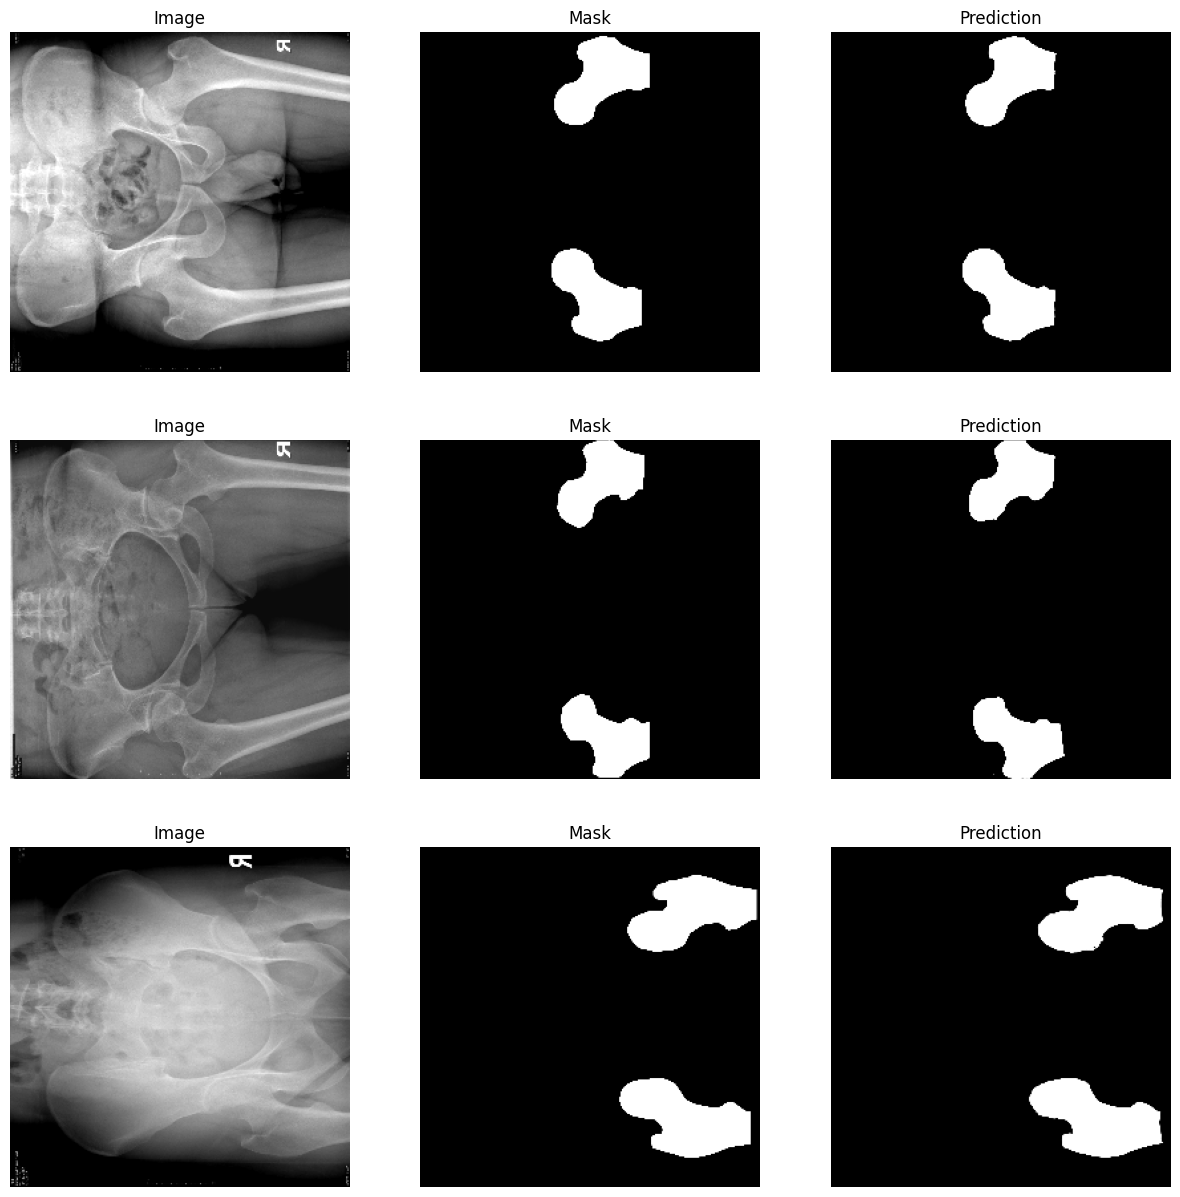

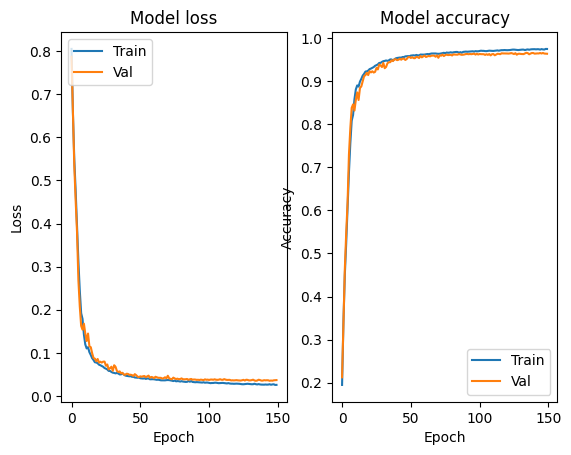

In [ ]:
for images, masks in test_batches.take(1):
    predictions = model.predict(images)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for ii, (img, msk, prediction) in enumerate(zip(images, masks, predictions)):
        axs[ii, 0].imshow(img, cmap='gray')
        axs[ii, 1].imshow(msk, cmap='gray')
        axs[ii, 2].imshow(prediction, cmap='gray')
        axs[ii, 0].axis("off")
        axs[ii, 1].axis("off")
        axs[ii, 2].axis("off")
        axs[ii, 0].set_title("Image")
        axs[ii, 1].set_title("Mask")
        axs[ii, 2].set_title("Prediction")
        if ii == 2:
            break

fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['dice_metric'])
axs[1].plot(history.history['val_dice_metric'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
rs_space={
    'lr': [10 ** -i for i in range(3,6)],
    'init': ['he_normal', 'glorot_uniform'],
    'dropout_rate': [i / 10 for i in range(1,10)]
}

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=get_second_model, epochs=150, batch_size=32, verbose=0)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1)

random_search_result = random_search.fit(train_batches)